# Hourly traffice volume prediction on Interstate 94

#### __Multivaraite time series perdiction with getML__

In this tutoiral, we demonstrate a time series application of getML. We predict the hourly traffic volume on I-94 westbound from Minneapolis-St Paul. 
We benchmark our results against [Facebook's Prophet](https://facebook.github.io/prophet/). It turned out that getML's relational learning algorithms outperform Prophet's classical time series approach by ~13 percent.

Summary:

- Prediction type: __Regression model__
- Domain: __Tranpsortion__
- Prediction target: __Hourly traffic volume__ 
- Source data: __Multivariate time series, 5 components__
- Population size: __24096__

_Author: Sören Nikolaus_

#### __Background__

The dataset features some particularly interesting characteristics common for time series, which classical models may struggle to appropriately deal with. Such characteristics are:

- High frequency (hourly)
- Dependence on irregular events (holidays)
- Strong and overlapping cycles (daily, weekly)
- Anomalies
- Multiple seasonalities


The analysis is built on top of a dataset provided by the [MN Department of Transportation](https://www.dot.state.mn.us), with some data preparation done by [John Hogue](https://github.com/dreyco676/Anomaly_Detection_A_to_Z/). 

Let's get started with the analysis and set-up your session

In [ ]:
import os
import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline  

import getml

print(f"getML API version: {getml.__version__}\n")

getml.engine.set_project('interstate94')

## 1. Loading data


### 1.1 Download from source

Downloading the raw data from the CTU Prague Relational Learning Repository into a prediction ready format takes time. To get to the getML model building as fast as possible, we prepared the data for you and excluded the code from this notebook. It will be made available in a future version.

In [4]:
data = getml.datasets.load_interstate(roles=True)
# population_train, population_test, order, trans, meta = data.values()

AttributeError: module 'getml.datasets' has no attribute 'load_interstate'

### 1.2 Prepare data for getML

The `getml.datasets.load_loans` method took care of the entire data lifting:
* Downloads csv's from our servers in python
* Converts csv's to getML [DataFrames]()
* Sets [roles]() to columns inside getML DataFrames

The only thing left is to set [units]() to columns that the relational learning algorithm is allowed to compare to each other.

__Data visualization__

The original data (image below) model is condensed into 4 tables: 

* A population table *population_{train/test}*, based on `loan` table
* Three peripheral tables: `order`, `trans`, and `meta`.

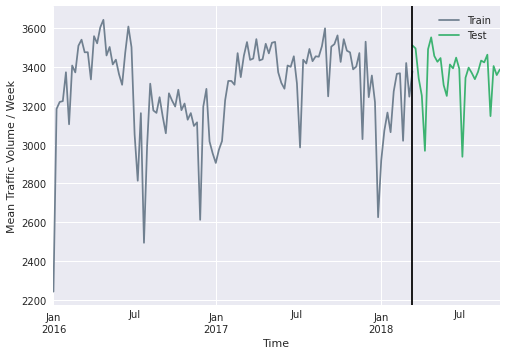

In [4]:
col_data = 'slategray'
col_getml = 'darkviolet'
col_getml_alt = 'coral'
col_prophet = 'cornflowerblue'

traffic[idx_train].set_index('ds').resample('1w').mean()['Traffic_Volume'].plot(label='Train', color=col_data)
traffic[~idx_train].set_index('ds').resample('1w').mean()['Traffic_Volume'].plot(label='Test', color='mediumseagreen')
plt.legend()
plt.ylabel('Mean Traffic Volume / Week')
plt.xlabel('Time')
plt.axvline(t_split, color='black')
plt.show()

__Traffic__: population table

To allow the algorithm to capture seasonal information, we include time components (such as the day of the week) as categorical variables.

In [6]:
# population DataFrame
# population_train

### 1.3 Define relational model

To start with relational learning, we need to specify the data model. We manually replicate the appropriate time series structure by setting time series related join conditions (`horizon`, `memory` and `allow_lagged_targets`). This is done abstractly using [Placeholders](https://docs.getml.com/latest/user_guide/data_model/data_model.html#placeholders)

The data model consists of two tables:
* __Population table__ holds target and the contemporarily available time-based components
* __Peripheral table__ same table as as the population table
* Join between both placeholders specifies (`horizon`) to prevent leaks and (`memory`) that keeps the the computations feasible

In [11]:
population = getml.data.Placeholder('population')

peripheral = getml.data.Placeholder('peripheral')

# 1. The horizon is 1 hour (we predict the next hour). 
# 2. The memory is 7 days, so we allow the algorithm to 
#    use information from up to 7 days. 
# 3. We allow lagged targets, thus the algorithm is able to 
#    identify autoregressive processes.

population.join(
    peripheral,
    join_key='join_key',
    time_stamp='ds',
    horizon=getml.data.time.hours(1),
    memory=getml.data.time.days(7),
    allow_lagged_targets=True
)

population

placeholder,other placeholder,allow lagged targets,horizon,join keys used,memory,other join keys used,other time stamps used,time stamps used,upper time stamps used
population,peripheral,True,3600.0,join_key,604800.0,join_key,ds,ds,


## 2.Predictive modelling

We loaded the data, defined the roles, units and the abstract data model. Next, we create a getML pipeline for relational learning.

### 2.1 getML Pipeline

<!-- #### 2.1.1  -->
__Set-up of feature learners, selectors & predictor__

In [12]:
multirel = getml.feature_learning.MultirelModel(
    num_features=10,
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    seed=4367
)

relboost = getml.feature_learning.RelboostModel(
    num_features=10,
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    seed=4367
)

predictor = getml.predictors.XGBoostRegressor(reg_lambda=500)

Pipeline(feature_learners=['MultirelModel', 'RelboostModel'], 
         feature_selectors=[], include_categorical=False, 
         peripheral=['peripheral'], population='population', 
         predictors=['XGBoostRegressor'], 
         tags=['memory: 7d', 'horizon: 1h', 'multirel', 'relboost'], 
         share_selected_features=0.5)

__Build the pipeline__

In [11]:
pipe = getml.pipeline.Pipeline(
    tags=['memory: 7d', 'horizon: 1h', 'multirel', 'relboost'],
    population=population,
    peripheral=[peripheral],
    feature_learners=[multirel, relboost],
    predictors=[predictor]
)

### 2.2 Model training

In [12]:
pipe.fit(df_train, [df_full])

Checking data model...
OK.

MultirelModel: Training features...
[========================================] 100%

RelboostModel: Training features...
[========================================] 100%

MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%

XGBoost: Training as feature selector...
[========================================] 100%

MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:0m:11.152945



Pipeline(feature_learners=['MultirelModel', 'RelboostModel'], 
         feature_selectors=['XGBoostClassifier'], include_categorical=False, 
         peripheral=['trans', 'order', 'meta'], population='population', 
         predictors=['XGBoostClassifier'], tags=[], 
         share_selected_features=0.8)

url: /user/getml-getml-demo-xac2mhf4/proxy/1709/getpipeline/1r9INb/0/

### 2.3 Model evaluation

In [15]:
in_sample = pipe.score(
        population_table=df_train,
        peripheral_tables=[df_full]
)

out_of_sample = pipe.score(
        population_table=df_test,
        peripheral_tables=[df_full]
)

print("""
In sample mae: {:.2f}
In sample rmse: {:.2f}
In sample rsquared: {:.2f}\n
Out of sample mae: {:.2f}
Out of sample rmse: {:.2f}
Out of sample rsquared: {:.2f}
""".format(
    in_sample['mae'][0], 
    in_sample['rmse'][0],
    in_sample['rsquared'][0],
    out_of_sample['accuracy'][0], 
    out_of_sample['auc'][0],
    out_of_sample['rsquared'][0])
)


MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%

In sample: {'mae': [219.24213417973056], 'rmse': [341.87796271075854], 'rsquared': [0.9697954651459705]}

MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%

Out of sample: {'mae': [205.05170746482753], 'rmse': [331.7133492664497], 'rsquared': [0.9721658295247855]}


### 2.4 Studying features

__Feature correlations__

Correlations of the calculated features with the target

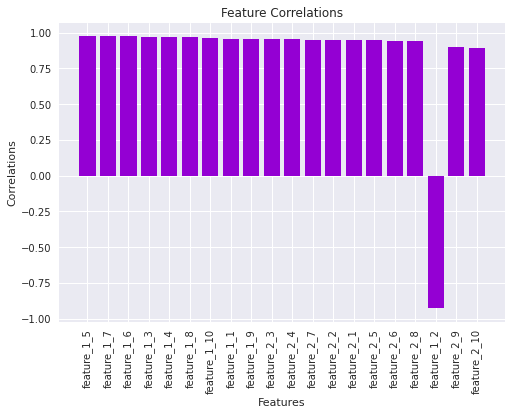

In [17]:
names, correlations = pipe.features.correlations()
plt.bar(names, correlations, color=col_getml)
plt.title('Feature Correlations')
plt.xlabel('Features')
plt.ylabel('Correlations')
plt.xticks(rotation='vertical')
plt.show()

__Feature importances__

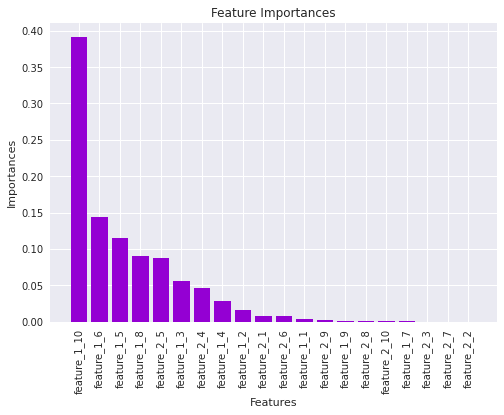

In [16]:
names, importances = pipe.features.importances()

plt.bar(names, importances, color=col_getml)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

most_important = names[0]

__Viszualizing the learned features__

SQL transpilation of most important feature Multirel feature. Here, Multirel aggregated past values of the target (from up to one week ago) conditonal on time-related components to resemble the daily, weekly and montly cycles in the series. We expect this approach to work reasonably well because the series exhibits strong and stable time-related patterns. 

In [19]:
pipe.features.to_sql()[most_important]

```sql
CREATE TABLE "FEATURE_1_10" AS
SELECT AVG( t2."Traffic_Volume" ) AS "feature_1_10",
       t1.rowid AS "rownum"
FROM "population" t1
LEFT JOIN "peripheral" t2
ON t1."join_key" = t2."join_key"
WHERE (
   ( ( datetime( t1."ds" ) > datetime( t2."ds", '+1.891459 hours' ) ) AND ( datetime( t1."ds" ) > datetime( t2."ds", '+6.987649 days' ) ) AND ( t2."hour" NOT IN ( '7', '11', '12', '13', '14', '17', '21' ) ) )
OR ( ( datetime( t1."ds" ) > datetime( t2."ds", '+1.891459 hours' ) ) AND ( datetime( t1."ds" ) <= datetime( t2."ds", '+6.987649 days' ) ) AND ( t1."hour" NOT IN ( '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '20', '21', '22', '23' ) ) AND ( t1."day" NOT IN ( '2', '6', '10', '11', '13', '23', '28', '30' ) ) )
OR ( ( datetime( t1."ds" ) <= datetime( t2."ds", '+1.891459 hours' ) ) AND ( t2."hour" NOT IN ( '0', '1', '2', '3', '22', '23' ) ) AND ( t2."Traffic_Volume" > 593.027027 ) )
OR ( ( datetime( t1."ds" ) <= datetime( t2."ds", '+1.891459 hours' ) ) AND ( t2."hour" IN ( '0', '1', '2', '3', '22', '23' ) ) AND ( t2."Traffic_Volume" > 4248.714286 ) )
) AND datetime( t2."ds", '+1.000000 hours' ) <= datetime( t1."ds" )
AND ( datetime( t2."ds", '+7.041667 days' ) > datetime( t1."ds" ) OR datetime( t2."ds", '+7.041667 days' ) IS NULL )
GROUP BY t1.rowid;
```

__Plot feature & traffic volume vs. time__

Plot the most important feature against the observed values of the target for the last 7 days of the training set. You can see that this feature closely follows the original series. Multirel was able to identify certain patterns in the series, including:
- Day and night separation 
- The daily commuting peeks (on weekdays)
- The decline on weekends



In [20]:
features = pipe.transform(df_train, [df_full], df_name=f'{pipe.name}_features')


MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%



In [ ]:
fig, ax1 = plt.subplots()

features.to_pandas().set_index('ds')[most_important].plot(ax=ax1, color=col_getml_alt)
ax1.set_ylabel('Feature 1', color=col_getml_alt)

ax2 = ax1.twinx()  
ax2.set_ylabel('Traffic Volume', color=col_data)
traffic[idx_train].set_index('ds')['Traffic_Volume'].plot(ax=ax2, color=col_data)

fig.tight_layout()
plt.xlim(t_split - pd.Timedelta('7d'), t_split)
plt.show()

## 3. Benchmark




## Forecasts with getML
In a second model, we only include deterministic features in our analysis. This model resembles component-based models like used by Prophet and is capable of delivering infinite horizon forecasts. The algorithm here only picks time-based components like daily or weekly cycles or seasonalities observed throughout the year. However, we would be able to deliver forecasts over any desireable horizon just by passing a dataframe consisting of solely time-based features to `predict()`, i.e. the timestamp itself, the hour, the weekday, the day, the month and the year. All this information is deterministic and thus avaiable for any given point in the future. Note that this constitutes a cornercase application of getML. 

We can basically reuse everything from above, but have to set the `allow_lagged_targets` join condition to `False` to prevent the algorithm from incorporating the lagged traffic volume. 

Score the forecast model.

We only lose about 2 percantage points of predictive accuracy when dropping all past information about the traffic volume. This is already a clear indication for the presence of strong and stabe time-related patterns in the series.

Now, we evaluate the learned features.

Here is the SQL transpilation of most important feature:

This is a Relboost feature and therefore less straightforward to interpret. But we can see that Relboost, based on the categorical time-based columns, is based similar rules when learning the weights as Multirel did above.

Let's have a look at the generated features plotted against observed values:

While the feature is less smooth, it is really close to what we got in the 1-step case. This is another indication for the prescence of strong time-related patterns in the data.

## Benchmarks against Prophet

By design, Prophet isn't capable of delivering the 1-step ahead predictions we did with getML. In order to retrieve a benchmark in the 1-step case nonetheless, we mimic 1-step ahead predictions through cross validating the model on a rolling origin. This clearly gives Prophet an advantage as all information up to the origin is incorporated when *fitting* the model and a new fit is calculated for every 1-step ahead forecast. Prophet's performance thus has to be viewed as an upper bound. Further, as noted above, we thought it would be interesting to let Multirel and Relboost figure out time based patterns by itself if we provide only deterministic components. So, in a second step, we benchmark this case against Prophet. For both tools, we use very simple models with all hyperparameters set to their default values.

Here we fit the model. We fit a new Prophet model for every hour. This is a computationally expensive operation even for our test subsample of 30 days. For the 720 hours (= 720 models) it takes around 6 hours. Therefore we read the predicitions from disc. If you want to reestimate the Prophet predicitions, you can rename the csv files on disc.

Score the model.

getML is able to outperform Prophet's 1-step ahead predictions by about 14 percentage points in terms of predictive accuracy. This is a substantial margin. But we have to state that it may be an unfair comparison because we use Prophet for an application it wasn't designed for. To deal with this critique we also calculate h-step predictions below.

Next, we visually compare the 1-step ahead Prophet with 1-step ahead getML predictions. 

Note that with getML we calculate predictions for the *full sample* (instead of just 30 days). This plays as another advantage for Prophet.

We inspect the predictions of both models over the course of a week. Here, we plot the getML and Prophet predictions against actual values (data).

What can we take from this plot? The strong time-related patterns carry on to the testing set and the xgboost is able to incorporate this information to deliver highly accurate 1-step ahead predictions. Notice that Prophets additive components model results in negative predictions for the weekends' lows at night. We can also see an anomaly on March, 24 that neither model is able to predict (feel free to play with the window to verify that its an annomaly).

Now we benchmark the performance of h-step ahead forecasts. Remember, in the models, only deterministic features are incorporated. Here, we fit the h-step ahead forecast with Prophet. This is how Prophet is meant to be applied. We allow for multiplicative seasonalities to at least partially remedy the problem with negative predictions discussed above.

A typical Prophet components graph. 

Seasonalities are now applied multiplicatively, but the combination of the totally bottoming out daily cycle and the negative additive trend will result in negative predictions nontheless.

Score the Prophet model.

Remember, getML's predicition accuracy in the h-step case was arround 94 %. So getML is still ahead of Prophet by about 12 percentage points. That is, competing with Prophet in its core business.

Here is a visual comparison of the h-step ahead forecasts:

We inspect the forecasts over the course of the same period as above.

We lose some accuracy but the predictions are still very accurate. All important time-related patterns are still present. And the combination of the features results in a relatively smooth approximation of the data.

## Augmenting the model with holiday data

In a last step, we augment data on national holidays. 

First, we import the holiday data. Holidays are deterministic, therefore we can include them in the population table and allow the algorithm to use contemporary information about whether the current day is a holiday or not. If this information was not contemporarly available, we would introduce a data leak here.

Now, we update data on the engine using the new pandas dataframe that includes holiday data.

Our data model still consists of two tables.

We see that our results don't get much better (compared to the 1-step ahead case above). Actually, the difference here is mere noise. But note that getML already delivered very accurate predictions before. And sometimes there is just no additional valuable information in the data. This is not that surprising for the holiday data, given that most information about holidays is fully reproducible from calendarial information we extracted earlier. In other words: for the algorithm, it doesn't matter if the traffic is lower on any 4th of July of a given year or if there is a corresponding holiday named 'Independence Day'.

The feature above is a nice example where Multirel correctly attributed lower levels of traffic to the presence of holidays like Independence Day, Thanksgiving or Christmas. Such include/exclude conditions based on categorical columns are really nice, as they demonstrate getML's powerful out-of-the-box handling of categorical variables.

## Conclusion
Applying getML to hourly traffic data from a metropolitan section of the interstate 94 we were able to show the power and relevance of the Multirel algorithm on a real-world data set with complex characteristics. We benchmarked our results against Prophet because we expect Prophet to perform well on the given data set. getML outperformed Prophet predictions by up to 14 percantage points. A typical application for the modelling strategy from above could be the real-time prediction of traffic volume (and traffic jams) on a navigation device. Using the trained features to generate new predictions should not take longer than a few milliseconds, even on a low-powered device.